In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np
import random
import time
import json
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [3]:
def get_dataloaders(forget_class=0, batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    idxs_f = [i for i, (_, y) in enumerate(trainset) if y == forget_class]
    idxs_r = [i for i, (_, y) in enumerate(trainset) if y != forget_class]
    forget_loader = DataLoader(Subset(trainset, idxs_f), batch_size=batch_size, shuffle=True)
    retain_loader = DataLoader(Subset(trainset, idxs_r), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    forget_eval_loader = DataLoader(Subset(trainset, idxs_f), batch_size=batch_size, shuffle=False)
    return trainset, forget_loader, retain_loader, test_loader, forget_eval_loader

def train_model(model, loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

def evaluate(model, loader, device, target_class=None):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            if target_class is not None:
                mask = (y == target_class)
                if mask.sum().item() > 0:
                    correct += (pred[mask] == y[mask]).sum().item()
                    total += mask.sum().item()
            else:
                correct += (pred == y).sum().item()
                total += y.size(0)
    return correct / total if total > 0 else 0

In [4]:
def generate_lev_examples(model, loader, device, epsilon=0.05, steps=10, lr=0.01, lam=0.01):
    model.eval()
    adv_examples = []
    adv_labels = []
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        delta = torch.randn_like(x) * 0.01
        delta.requires_grad_()
        
        for _ in range(steps):
            out = model(x + delta)
            loss = criterion(out, y) + lam * delta.norm()
            loss.backward()

            if delta.grad is not None:
                delta.data = (delta + lr * delta.grad).clamp(-epsilon, epsilon)
                delta.grad.zero_()
        x_adv = (x + delta).detach()
        with torch.no_grad():
            y_adv = model(x_adv).argmax(dim=1)
        mask = (y_adv != y)
        if mask.sum() > 0:
            adv_examples.append(x_adv[mask].cpu())
            adv_labels.append(y_adv[mask].cpu())
    if adv_examples:
        return torch.cat(adv_examples), torch.cat(adv_labels)
    else:
        return torch.empty(0), torch.empty(0, dtype=torch.long)

In [5]:
def unified_unlearning_with_tracking(model, x_adv, y_adv, retain_loader, forget_loader, device, epochs=3, batch_size=64, track_every=50, lr=0.01):
    """
    Performs a unified unlearning process by fine-tuning on a mixed dataset
    of adversarial examples (from forget set) and original retain set examples.
    """
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # 1. Extract all data from retain_loader
    retain_images = []
    retain_labels = []
    for x, y in retain_loader:
        retain_images.append(x)
        retain_labels.append(y)
    
    retain_images_tensor = torch.cat(retain_images, dim=0)
    retain_labels_tensor = torch.cat(retain_labels, dim=0)
    
    # 2. Combine adversarial examples and retain examples
    # Note: x_adv and y_adv are already on CPU from generate_lev_examples
    combined_images = torch.cat([x_adv, retain_images_tensor], dim=0)
    combined_labels = torch.cat([y_adv, retain_labels_tensor], dim=0)
    
    # 3. Create a new unified DataLoader
    combined_dataset = TensorDataset(combined_images, combined_labels)
    combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    
    print(f"Unified training on {len(combined_dataset)} samples ({len(x_adv)} adversarial, {len(retain_images_tensor)} retained).")

    # 4. Run the unified training loop
    batch_count = 0
    forget_acc_history, retain_acc_history, batch_history = [], [], []
    for epoch in range(epochs):
        print(f"--- Unified Unlearning Epoch {epoch+1}/{epochs} ---")
        for xb, yb in combined_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            
            # Tracking performance
            if batch_count % track_every == 0:
                forget_acc = evaluate(model, forget_loader, device, target_class=0)
                retain_acc = evaluate(model, retain_loader, device)
                forget_acc_history.append(forget_acc)
                retain_acc_history.append(retain_acc)
                batch_history.append(batch_count)
                print(f"Batch {batch_count}: Forget acc = {forget_acc:.4f}, Retain acc = {retain_acc:.4f}")
            batch_count += 1
            
    return forget_acc_history, retain_acc_history, batch_history

In [6]:
def plot_training_curves(batch_history, forget_acc_history, retain_acc_history, save_path='lev_unified_training_curves.png'):
    plt.figure(figsize=(10, 6))
    plt.plot(batch_history, forget_acc_history, 'r-', label='Forget Class Accuracy', linewidth=2)
    plt.plot(batch_history, retain_acc_history, 'b-', label='Retain Set Accuracy', linewidth=2)
    plt.xlabel('Batch Count')
    plt.ylabel('Accuracy')
    plt.title('LEV Unified Unlearning Training Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_tsne(model, original_loader, device, title, save_path, adv_examples=None, adv_labels=None, forget_class_index=0):
    model.eval()
    features = []
    
    def hook(module, input, output):
        features.append(output.view(output.size(0), -1).detach().cpu())
    hook_handle = model.avgpool.register_forward_hook(hook)

    original_labels = []
    with torch.no_grad():
        for x, y in original_loader:
            model(x.to(device))
            original_labels.extend([f'Original Forget Class ({forget_class_index})'] * len(x))
    
    if adv_examples is not None and adv_labels is not None:
        adv_dataset = TensorDataset(adv_examples, adv_labels)
        adv_loader = DataLoader(adv_dataset, batch_size=original_loader.batch_size)
        with torch.no_grad():
            for x_adv, y_adv in adv_loader:
                model(x_adv.to(device))
                original_labels.extend([f'Adversarial (Target: {l.item()})' for l in y_adv])

    hook_handle.remove()
    
    all_features = torch.cat(features).numpy()

    print(f"Running t-SNE on {all_features.shape[0]} samples...")
    tsne = TSNE(n_components=2, perplexity=min(30, len(all_features)-1), n_iter=1000, random_state=42)
    tsne_results = tsne.fit_transform(all_features)
    
    plt.figure(figsize=(12, 10))
    num_unique_labels = len(set(original_labels))
    palette = sns.color_palette("husl", num_unique_labels)
    
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=original_labels,
        palette=palette,
        alpha=0.7,
        s=50
    )
    
    plt.title(title, fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"t-SNE plot saved to {save_path}")


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
forget_class = 0
trainset, forget_loader, retain_loader, test_loader, forget_eval_loader = get_dataloaders(forget_class, batch_size=128)
model = models.resnet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# 1. Pretraining
print('Pretraining...')
train_model(model, DataLoader(trainset, batch_size=128, shuffle=True), criterion, optimizer, device, epochs=5)
acc_before_f = evaluate(model, forget_eval_loader, device, target_class=forget_class)
acc_before_r = evaluate(model, retain_loader, device)
acc_before_test = evaluate(model, test_loader, device)
print(f"[Before Unlearning] Forget class acc: {acc_before_f:.4f}, Retain acc: {acc_before_r:.4f}, Test acc: {acc_before_test:.4f}")

Files already downloaded and verified
Files already downloaded and verified
Pretraining...
[Before Unlearning] Forget class acc: 0.7630, Retain acc: 0.7326, Test acc: 0.6736



Visualizing t-SNE before unlearning...
Running t-SNE on 5000 samples...


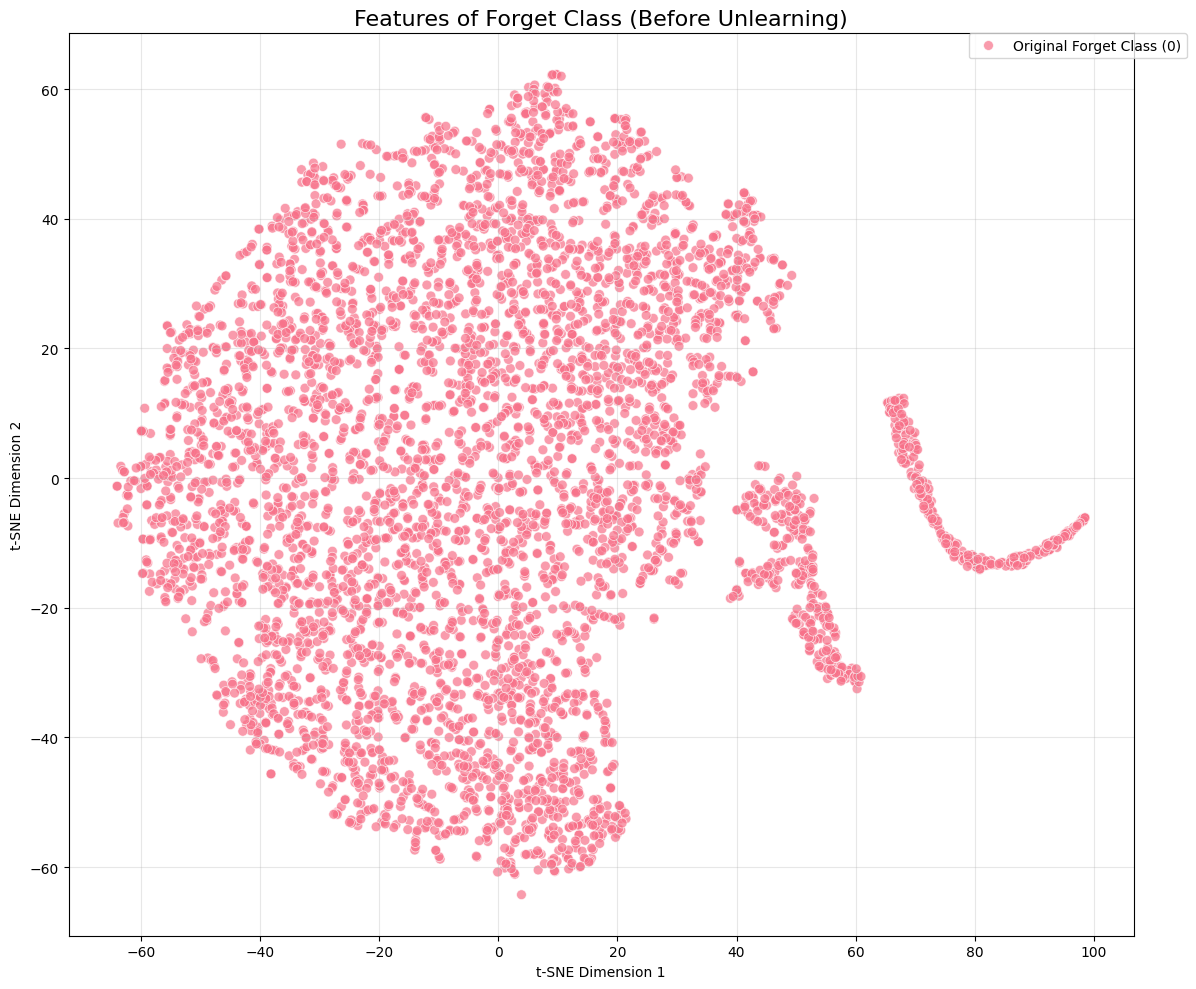

t-SNE plot saved to tsne_before_unlearning.pdf


In [8]:
# Before Unlearning t-SNE
print("\nVisualizing t-SNE before unlearning...")
visualize_tsne(model, forget_eval_loader, device, "Features of Forget Class (Before Unlearning)", "tsne_before_unlearning.pdf", forget_class_index=forget_class)


Generating LEV adversarial examples...
Adversarial examples generated: 1261

Visualizing t-SNE with adversarial examples...
Running t-SNE on 6261 samples...


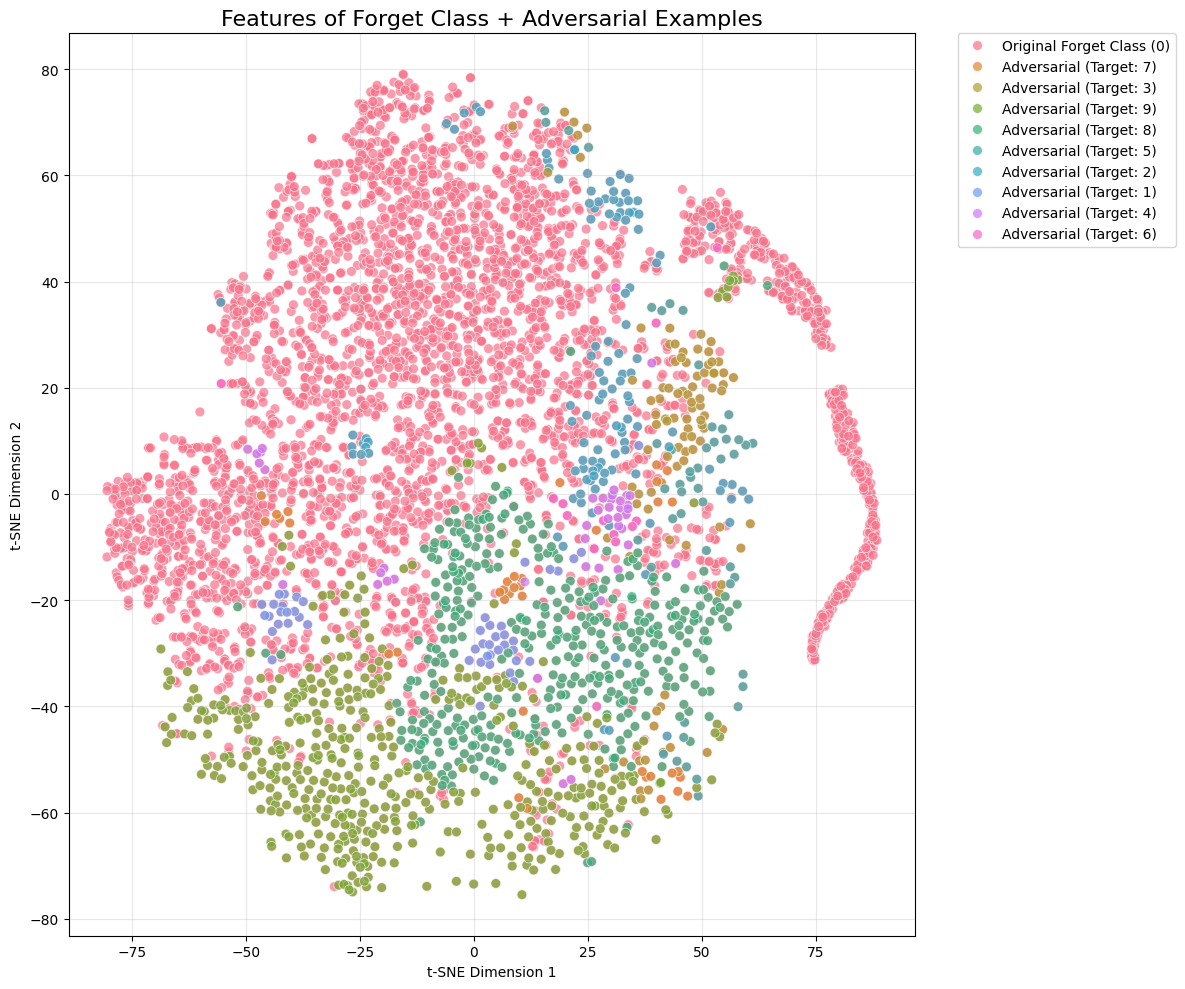

t-SNE plot saved to tsne_with_adversarial.pdf

Starting Unified Unlearning Process...
Unified training on 46261 samples (1261 adversarial, 45000 retained).
--- Unified Unlearning Epoch 1/3 ---
Batch 0: Forget acc = 0.7614, Retain acc = 0.7409
Batch 50: Forget acc = 0.3936, Retain acc = 0.7828
Batch 100: Forget acc = 0.2584, Retain acc = 0.7704
Batch 150: Forget acc = 0.2472, Retain acc = 0.7855
Batch 200: Forget acc = 0.2806, Retain acc = 0.8027
Batch 250: Forget acc = 0.2168, Retain acc = 0.8046
Batch 300: Forget acc = 0.2048, Retain acc = 0.8064
Batch 350: Forget acc = 0.1826, Retain acc = 0.7931
--- Unified Unlearning Epoch 2/3 ---
Batch 400: Forget acc = 0.1512, Retain acc = 0.7996
Batch 450: Forget acc = 0.1412, Retain acc = 0.7988
Batch 500: Forget acc = 0.1516, Retain acc = 0.8062
Batch 550: Forget acc = 0.1286, Retain acc = 0.7838
Batch 600: Forget acc = 0.1320, Retain acc = 0.8057
Batch 650: Forget acc = 0.1436, Retain acc = 0.8123
Batch 700: Forget acc = 0.1252, Retain acc = 

In [9]:
# 2. LEV Unified Unlearning
print('\nGenerating LEV adversarial examples...')
t0 = time.time()
x_adv, y_adv = generate_lev_examples(model, forget_eval_loader, device, epsilon=0.2, steps=20, lr=0.02, lam=0.05)
print(f'Adversarial examples generated: {x_adv.size(0)}')

if x_adv.size(0) > 0:
    # t-SNE with adversarial examples
    print("\nVisualizing t-SNE with adversarial examples...")
    visualize_tsne(model, forget_eval_loader, device, "Features of Forget Class + Adversarial Examples", "tsne_with_adversarial.pdf", adv_examples=x_adv, adv_labels=y_adv, forget_class_index=forget_class)
    
    print('\nStarting Unified Unlearning Process...')
    # Call the new unified function. The consolidation step is no longer needed.
    forget_acc_history, retain_acc_history, batch_history = unified_unlearning_with_tracking(
        model, x_adv, y_adv, retain_loader, forget_eval_loader, device, epochs=3, batch_size=128, track_every=50, lr=0.05
    )
else:
    print("No adversarial examples were generated. Skipping unlearning.")
    forget_acc_history, retain_acc_history, batch_history = [], [], []

t1 = time.time()

[After Unified LEV] Forget class acc: 0.0926, Retain acc: 0.8166, Test acc: 0.6629
Unified LEV Unlearning Time: 209.54 seconds

Visualizing t-SNE after unlearning...
Running t-SNE on 5000 samples...


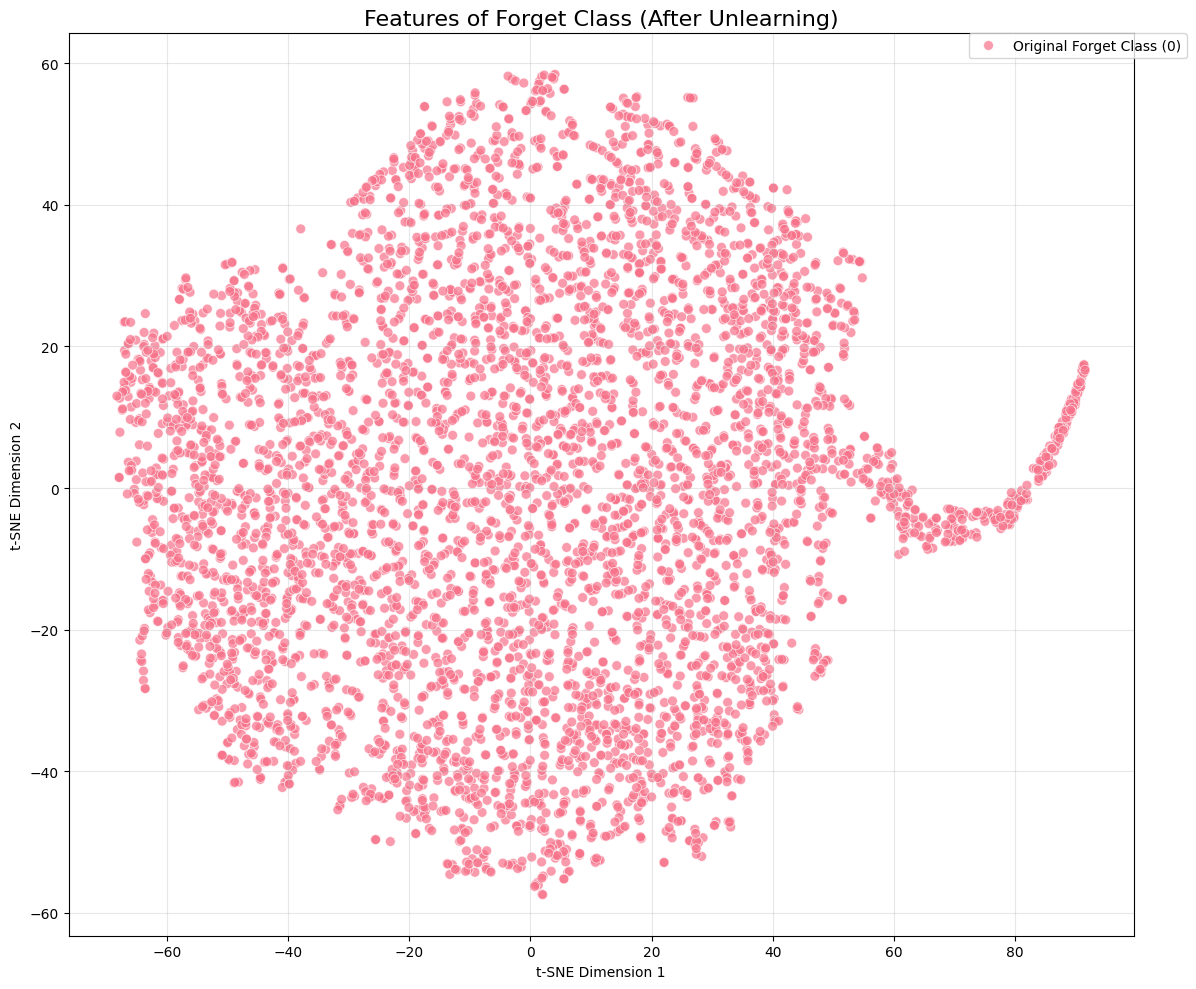

t-SNE plot saved to tsne_after_unlearning.pdf

Plotting training curves...


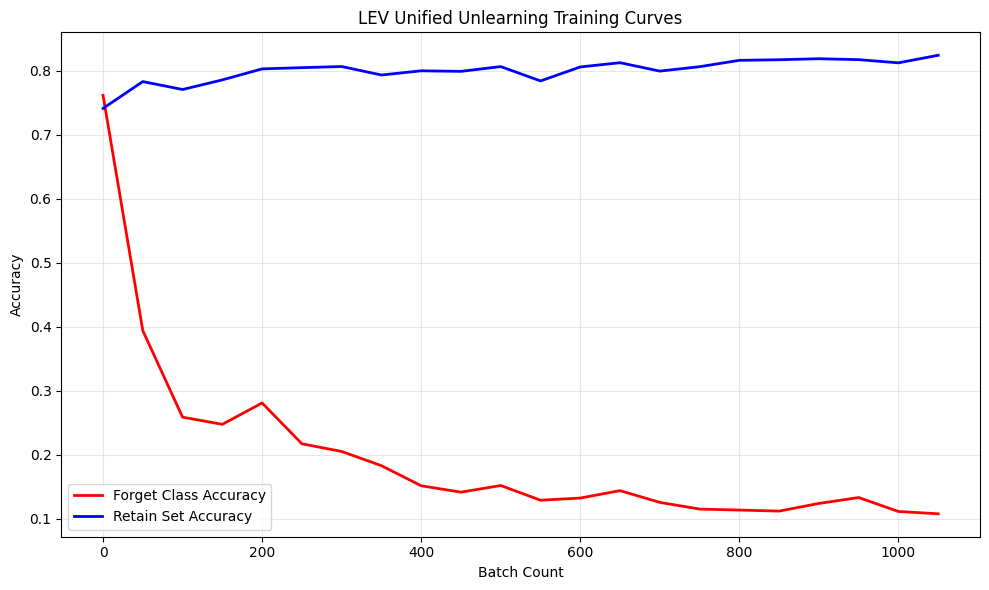

In [10]:
# Final evaluation
acc_lev_f = evaluate(model, forget_eval_loader, device, target_class=forget_class)
acc_lev_r = evaluate(model, retain_loader, device)
acc_lev_test = evaluate(model, test_loader, device)
print(f"[After Unified LEV] Forget class acc: {acc_lev_f:.4f}, Retain acc: {acc_lev_r:.4f}, Test acc: {acc_lev_test:.4f}")
print(f"Unified LEV Unlearning Time: {t1-t0:.2f} seconds")

# After Unlearning t-SNE
print("\nVisualizing t-SNE after unlearning...")
visualize_tsne(model, forget_eval_loader, device, "Features of Forget Class (After Unlearning)", "tsne_after_unlearning.pdf", forget_class_index=forget_class)

# Plotting and saving results...
if batch_history:
    print('\nPlotting training curves...')
    plot_training_curves(batch_history, forget_acc_history, retain_acc_history)

In [11]:
tracking_dict = {
    "batch_history": batch_history, "forget_acc_history": forget_acc_history, "retain_acc_history": retain_acc_history,
    "final_forget_acc": acc_lev_f, "final_retain_acc": acc_lev_r, "final_test_acc": acc_lev_test, "training_time": t1-t0
}
for k in tracking_dict.keys():
    if isinstance(tracking_dict[k], list):
        tracking_dict[k] = [float(x) for x in tracking_dict[k]]
with open("lev_unified_training_history.json", "w") as f:
    json.dump(tracking_dict, f, indent=2)
print('Training history saved to lev_unified_training_history.json')

# Summary
print(f"""
    ==== LEV Unified Experiment Summary ====
    [Before Unlearning]
    Forget class acc:   {acc_before_f:.4f}
    Retain class acc:   {acc_before_r:.4f}
    Test acc:           {acc_before_test:.4f}

    [After Unified LEV Unlearning]
    Forget class acc:   {acc_lev_f:.4f}
    Retain class acc:   {acc_lev_r:.4f}
    Test acc:           {acc_lev_test:.4f}
    Time:               {t1-t0:.2f} s
    ======================================
    """)

Training history saved to lev_unified_training_history.json

    ==== LEV Unified Experiment Summary ====
    [Before Unlearning]
    Forget class acc:   0.7630
    Retain class acc:   0.7326
    Test acc:           0.6736

    [After Unified LEV Unlearning]
    Forget class acc:   0.0926
    Retain class acc:   0.8166
    Test acc:           0.6629
    Time:               209.54 s
    
